In [116]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
%matplotlib inline

In [12]:
train_df = pd.read_json('datasets/train.json')

# Drop Duplicates

In [13]:
print(train_df.shape)
duplicate_columns = ['bathrooms', 'bedrooms', 'building_id', 'description', 'display_address', 'latitude', 'longitude', 'manager_id', 'price', 'street_address']
train_df_deduped = train_df.drop_duplicates(duplicate_columns)
print(train_df_deduped.shape)

(49352, 15)
(45259, 15)


In [ ]:
train_df_deduped = train_df_deduped[train_df_deduped['price'] > 50] 

In [72]:
train_df_deduped.sort('price', ascending = False).head()

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,description_length,num_photos,num_features
32611,1.0,2,cd25bbea2af848ebe9821da820b725da,2016-06-24 05:02:11,,Hudson Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",low,40.7299,7208764,-74.0071,d1737922fe92ccb0dc37ba85589e6415,[],4490000,421 Hudson Street,0,0,5
12168,1.0,2,5d3525a5085445e7fcd64a53aac3cb0a,2016-06-24 05:02:58,,West 116th Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",low,40.8011,7208794,-73.9480,d1737922fe92ccb0dc37ba85589e6415,[],1150000,40 West 116th Street,0,0,5
55437,1.0,1,37385c8a58176b529964083315c28e32,2016-05-14 05:21:28,,West 57th Street,"[Doorman, Cats Allowed, Dogs Allowed]",low,40.7676,7013217,-73.9844,8f5a9c893f6d602f4953fcc0b8e6e9b4,[],1070000,333 West 57th Street,8,0,3
57803,1.0,1,37385c8a58176b529964083315c28e32,2016-05-19 02:37:06,This 1 Bedroom apartment is located on a prime...,West 57th Street,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",low,40.7676,7036279,-73.9844,18133bc914e6faf6f8cc1bf29d66fc0d,[https://photos.renthop.com/2/7036279_924b52f0...,1070000,333 West 57th Street,1035,7,5
123877,0.0,0,b9c72643feb2652536a898a5f13d2543,2016-04-12 02:11:10,"Originally built in 1862, this extraordinary l...",Duane Street,"[Elevator, Pre-War, Terrace, Dogs Allowed, Cat...",low,40.7161,6857401,-74.0080,d98acd4fa3c463bd468603bd873cc54c,[https://photos.renthop.com/2/6857401_a4a4c2f2...,135000,144 Duane Street,1869,20,5


# Feature Engineering

In [18]:
train_df_deduped['description_length'] = train_df_deduped['description'].apply(lambda x: len(x))

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
train_df_deduped['num_photos'] = train_df_deduped['photos'].apply(lambda x: len(x))

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
train_df_deduped['num_features'] = train_df_deduped['features'].apply(lambda x: len(x))

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Dataset Split

In [75]:
X = train_df_deduped.drop('interest_level', axis = 1)
y = train_df_deduped['interest_level']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [77]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31681, 17)
(13578, 17)
(31681L,)
(13578L,)


In [79]:
y_train_split = {key: value*1.0/y_train.shape[0] for key, value in zip(y_train.value_counts().keys(),y_train.value_counts())}
y_test_split = {key: value*1.0/y_test.shape[0] for key, value in zip(y_test.value_counts().keys(),y_test.value_counts())}
for key in y_train_split.keys():
    print("{0}: {1:.4f} | {2:.4f}".format(key, y_train_split[key], y_test_split[key]))

high: 0.0746 | 0.0798
medium: 0.2208 | 0.2192
low: 0.7046 | 0.7011


# Base Model

In [80]:
base_features_to_use = ['bathrooms', 'bedrooms', 'price']

In [110]:
basic_logreg = LogReg(solver = 'newton-cg', multi_class = 'multinomial')
basic_logreg.fit(X_train[base_features_to_use], y_train.values)
y_pred = basic_logreg.predict(X_test[base_features_to_use])

Accuracy: 0.6993


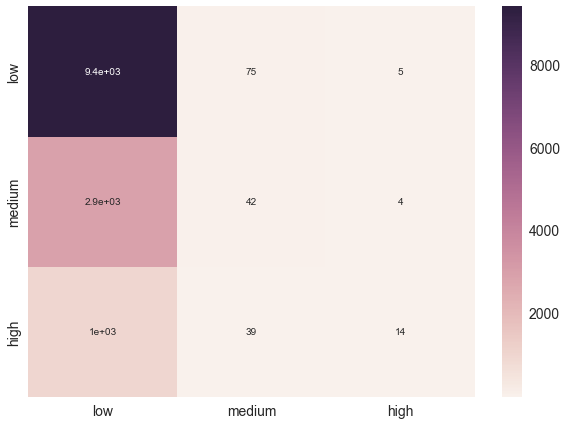

In [127]:
print("Accuracy: {0:.4f}".format(basic_logreg.score(X_test[base_features_to_use], y_test)))
cm = confusion_matrix(y_test, y_pred, labels = ['low', 'medium', 'high'])
df_cm = pd.DataFrame(cm, index = ['low', 'medium', 'high'], columns = ['low', 'medium', 'high'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [128]:
pred_prob = basic_logreg.predict_proba(X_test[base_features_to_use])
log_loss(y_test, pred_prob)

0.72533915110502167

0.72533915110502167